In [ ]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kstest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme()

Load the Data Set

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/car_insurance.csv')
df.style.set_properties(**{'border': '1px solid black', 'color': 'black', 'background-color': '#f4f4f4'})
df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,0,1,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,0,0,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,0,1,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,1,1,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


Data Cleaning

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis                 10000 non-null  

The dataset has 10000 rows and 17 columns. There are 5 categorical columns and 12 numerical columns.

There are 2 columns 'credit_score' and 'annual_milage' with missing values. They are needed to predict auto insurance claim

Display sum of missing data

In [ ]:
df.isnull().sum()

,0
id,0
age,0
gender,0
driving_experience,0
education,0
income,0
credit_score,982
vehicle_ownership,0
vehicle_year,0
married,0


Check for duplicates

In [ ]:
df.duplicated().value_counts()

,count
False,10000


Check if duplicates in the 'id' column

In [ ]:
# Check if duplicates in the 'id' column
id_unique = len(set(df.id))
id_total = df.shape[0]
id_dup = id_unique - id_total

print("duplicates in the 'id' column = ",id_dup)

duplicates in the 'id' column =  0


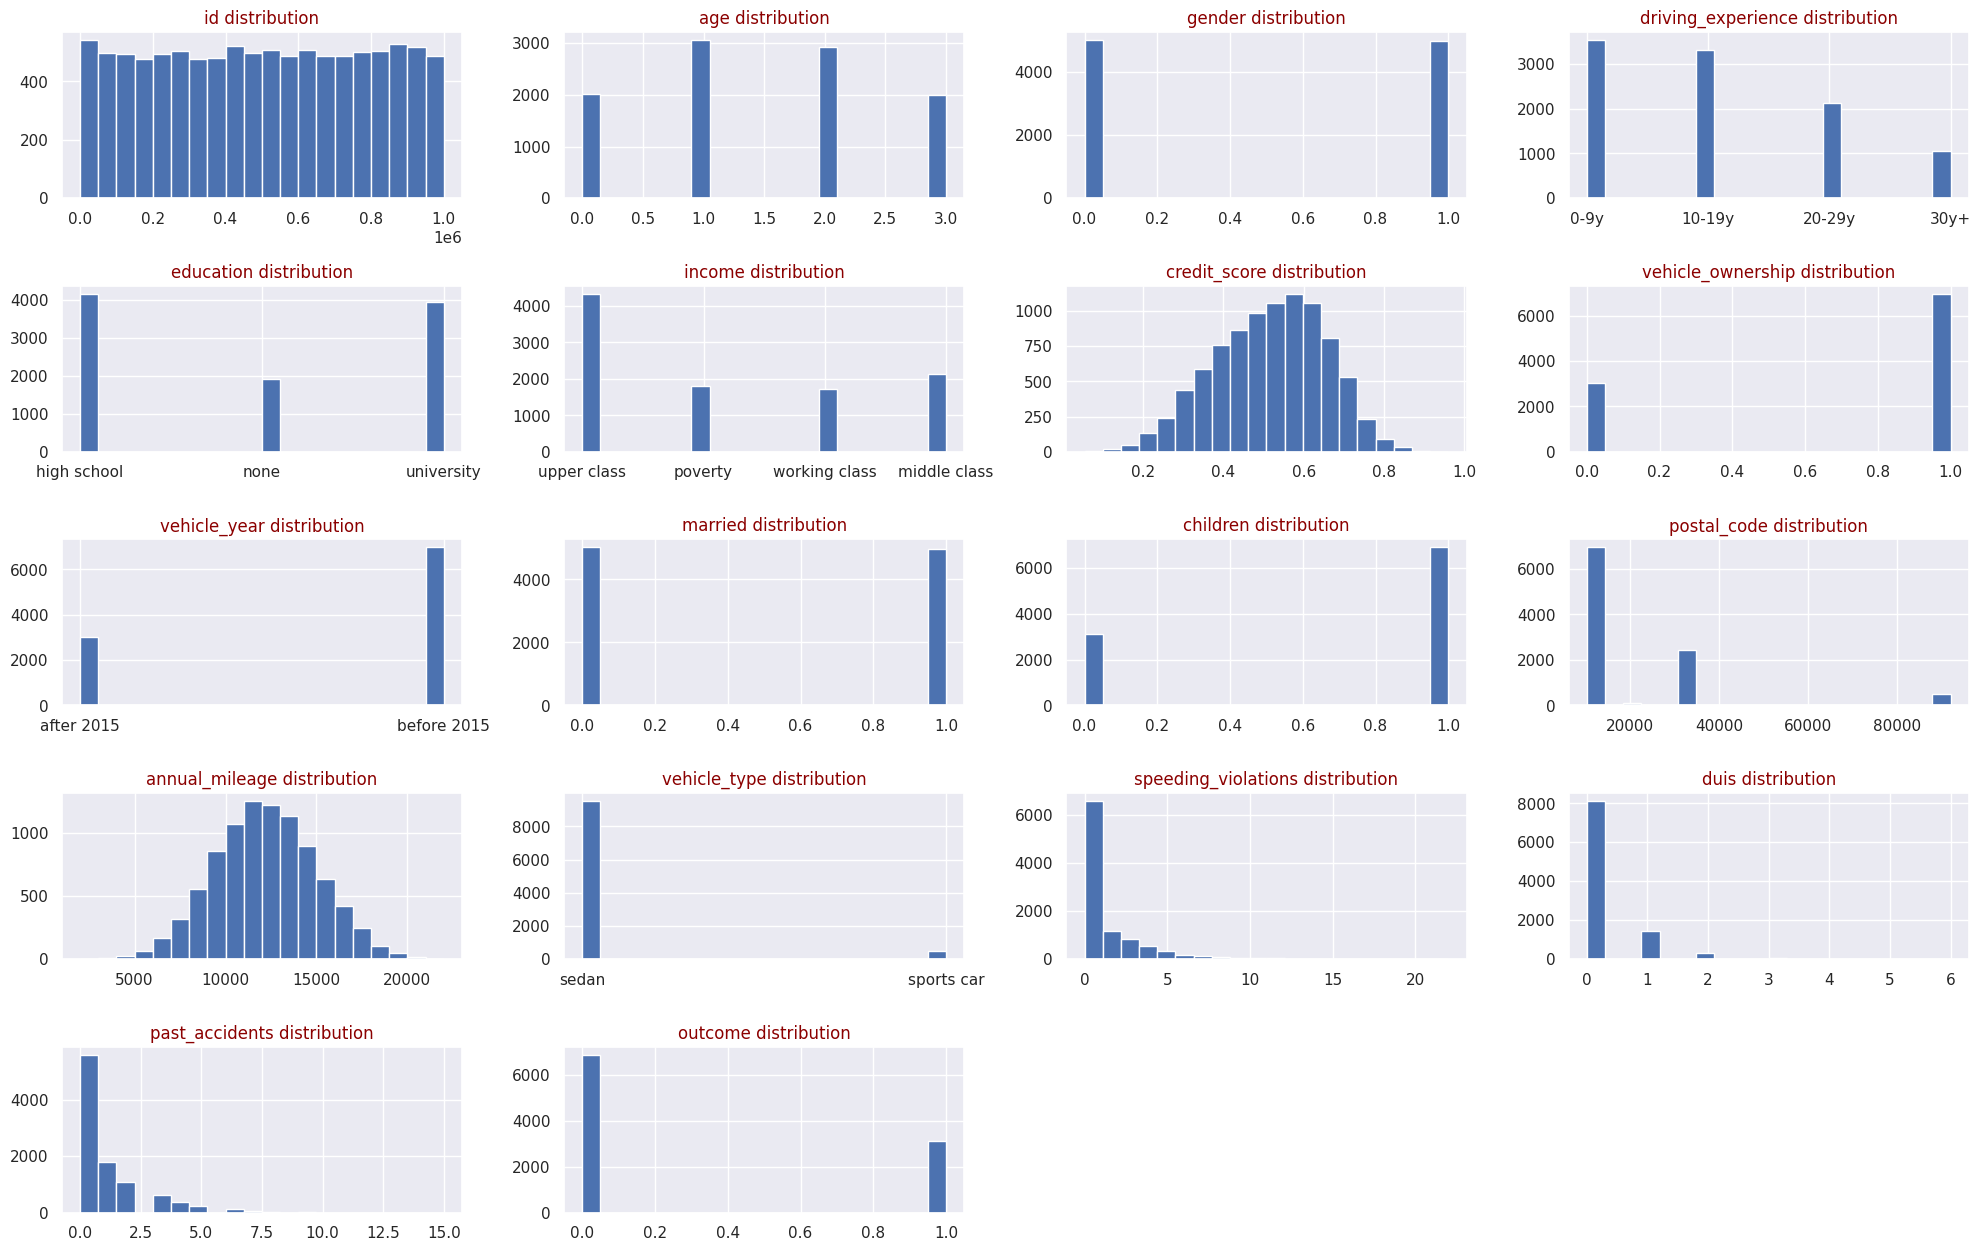

In [ ]:
# Plot histogram all columns
def draw_histograms(dataframe, features, rows, cols):

    fig = plt.figure(figsize=(20,20))

    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax)
        ax.set_title(feature+' distribution', color='darkRed')

    fig.tight_layout()
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.show()

draw_histograms(df, df.columns, 8, 4)

We will create a copy of the insurance_df dataframe to test if imputing missing values in those 2 important columns will work or not

In [ ]:
insurance_df_copy = df.copy()

The distribution of 'credit_score' looks a bit left skewed, fill in the null values here with the median value. It has a high number of missing values

In [ ]:
insurance_df_copy['credit_score'] = insurance_df_copy['credit_score'].fillna((insurance_df_copy['credit_score'].median()))

Check if the missing values are treated

In [ ]:
insurance_df_copy['credit_score'].isnull().sum()

np.int64(0)

Plot the 'credit_score' column if we were to fill in the null values with the median. May not be a good idea to use the median or mean to fill in missing values, as they'll distort the distribution

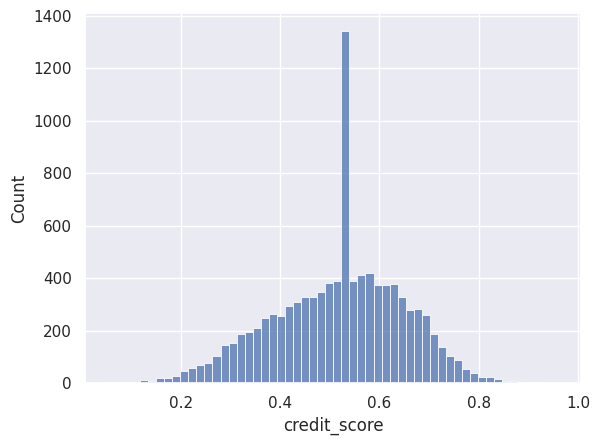

In [ ]:
sns.histplot(data=insurance_df_copy, x='credit_score')
plt.show()

Plot the 'annual_mileage' column if we were to fill in the null values with the mean. May not be a good idea to use the median or mean to fill in missing values, as they'll distort the distribution


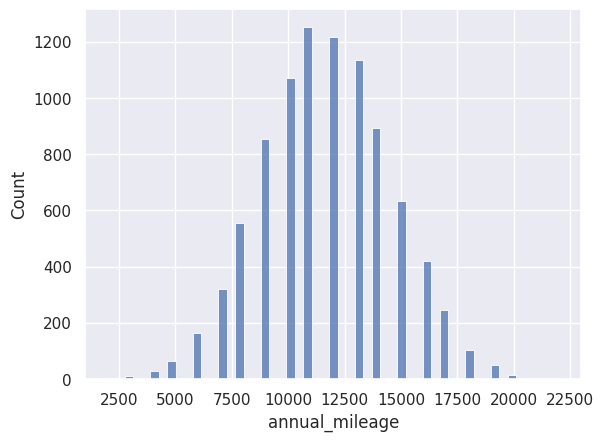

In [ ]:
sns.histplot(data=insurance_df_copy, x='annual_mileage')
plt.show()

Encode categorical columns with 'object' datatype:

In [ ]:
# Create a copy dataframe with just object data type
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,driving_experience,education,income,vehicle_year,vehicle_type
0,0-9y,high school,upper class,after 2015,sedan
1,0-9y,none,poverty,before 2015,sedan
2,0-9y,high school,working class,before 2015,sedan
3,0-9y,university,working class,before 2015,sedan
4,10-19y,none,working class,before 2015,sedan


In [ ]:
# Create a copy dataframe with just object data type
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,driving_experience,education,income,vehicle_year,vehicle_type
0,0-9y,high school,upper class,after 2015,sedan
1,0-9y,none,poverty,before 2015,sedan
2,0-9y,high school,working class,before 2015,sedan
3,0-9y,university,working class,before 2015,sedan
4,10-19y,none,working class,before 2015,sedan


CHECKING UNIQUE VALUES IN THE DATASET

Check unique values of 'driving_experience'

In [ ]:
obj_df['driving_experience'].value_counts()

,count
driving_experience,
0-9y,3530
10-19y,3299
20-29y,2119
30y+,1052


Check unique values of 'education'

In [ ]:
obj_df['education'].value_counts()

,count
education,
high school,4157
university,3928
none,1915


Check unique values of 'income'


In [ ]:
obj_df['income'].value_counts()

,count
income,
upper class,4336
middle class,2138
poverty,1814
working class,1712


Check unique values of 'vehicle_year'

In [ ]:
obj_df['vehicle_year'].value_counts()

,count
vehicle_year,
before 2015,6967
after 2015,3033


Check unique values of 'vehicle_type'

In [ ]:
obj_df['vehicle_type'].value_counts()

,count
vehicle_type,
sedan,9523
sports car,477


In [ ]:
cat_encode_dict = {"driving_experience": {"0-9y": 0, "10-19y": 1, "20-29y": 3, "30y+": 4},
                   "education": {"none": 0, "high school": 1, "university": 2},
                   "income": {"poverty": 0, "working class": 1, "upper class": 2, "middle class": 3},
                   "vehicle_year": {"before 2015": 0, "after 2015": 1},
                   "vehicle_type": {"sedan": 0, "sports car": 1}
                   }

obj_df = obj_df.replace(cat_encode_dict)
obj_df

,driving_experience,education,income,vehicle_year,vehicle_type
0,0,1,2,1,0
1,0,0,0,0,0
2,0,1,1,0,0
3,0,2,1,0,0
4,1,0,1,0,0
...,...,...,...,...,...
9995,1,2,2,0,0
9996,1,0,3,1,0
9997,0,1,3,0,0
9998,1,1,0,0,0


Reassign those encoded values from the 'obj_df' dataframe back to insurance df

In [ ]:
df[obj_df.columns] = obj_df
df

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0,1,2,0.629027,1.0,1,0.0,1.0,10238,12000.0,0,0,0,0,0.0
1,750365,0,1,0,0,0,0.357757,0.0,0,0.0,0.0,10238,16000.0,0,0,0,0,1.0
2,199901,0,0,0,1,1,0.493146,1.0,0,0.0,0.0,10238,11000.0,0,0,0,0,0.0
3,478866,0,1,0,2,1,0.206013,1.0,0,0.0,1.0,32765,11000.0,0,0,0,0,0.0
4,731664,1,1,1,0,1,0.388366,1.0,0,0.0,0.0,32765,12000.0,0,2,0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,323164,1,0,1,2,2,0.582787,1.0,0,0.0,0.0,10238,16000.0,0,0,0,1,0.0
9996,910346,1,0,1,0,3,0.522231,1.0,1,0.0,1.0,32765,NaN,0,1,0,0,0.0
9997,468409,1,1,0,1,3,0.470940,1.0,0,0.0,1.0,10238,14000.0,0,0,0,0,0.0
9998,903459,1,0,1,1,0,0.364185,0.0,0,0.0,1.0,10238,13000.0,0,2,0,1,1.0


Detect outliers in some numerical columns need further investigation:

In [ ]:
numeric_cols = df[['credit_score', 'annual_mileage', 'speeding_violations', 'duis', 'past_accidents']]

Plot the suspected columns with outliers to see pairwise relationships betwwen them

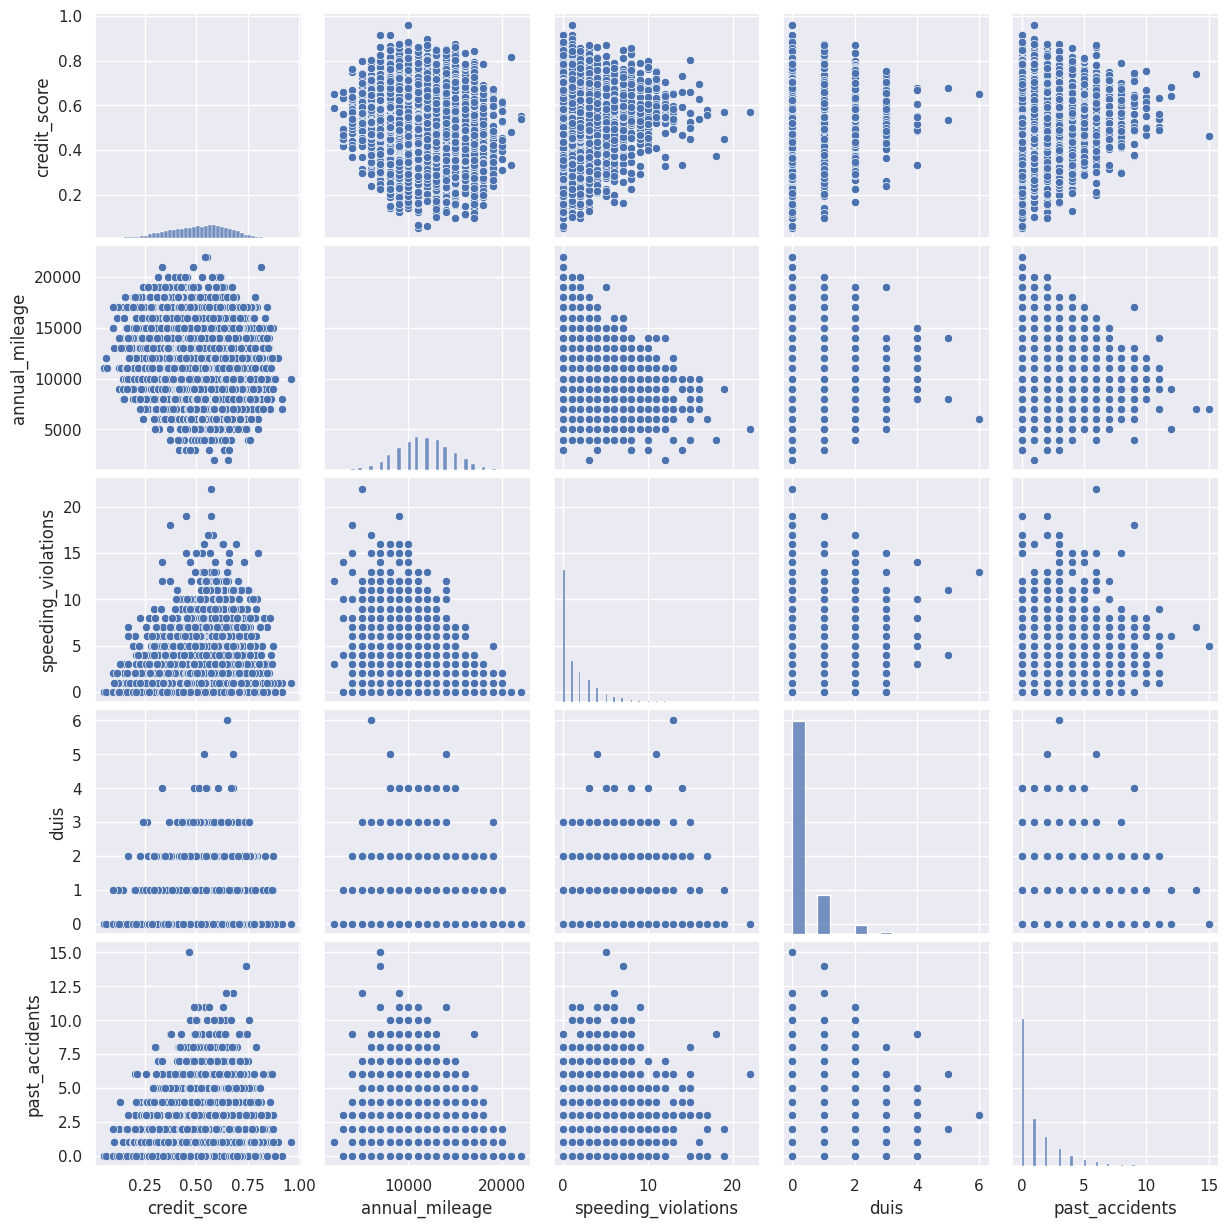

In [ ]:
sns.pairplot(numeric_cols)
plt.show()

There are some outliers across our suspected columns but there also doesn't seem to have a linear relationship between them. As we're not sure about determining the trend line to best fit them, let's leave them as is. Note that the spreads of 'credit_score' and 'annual_mileage' are very far from the center, we might need to scale the data later on.

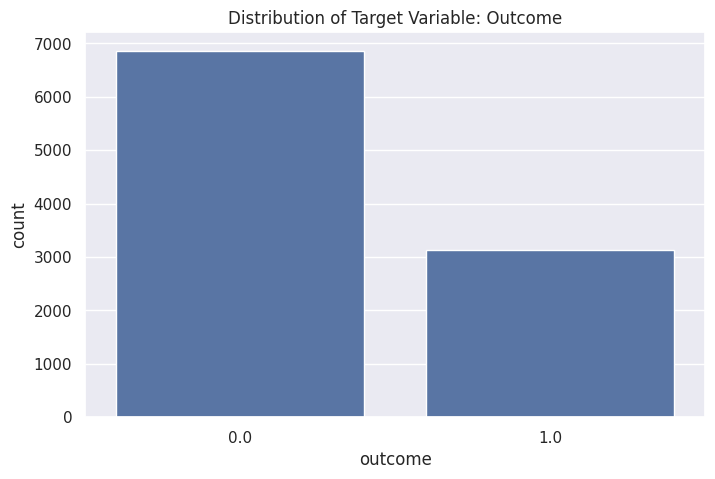


Missing Values:
credit_score      982
annual_mileage    957
dtype: int64


,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,1.489500,0.499000,1.386400,1.20130,1.679800,0.515813,0.697000,0.303300,0.498200,0.688800,19864.548400,11697.003207,0.047700,1.482900,0.23920,1.056300,0.313300
std,290030.768758,1.025278,0.500024,1.413611,0.73745,1.004078,0.137688,0.459578,0.459707,0.500022,0.463008,18915.613855,2818.434528,0.213141,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.053358,0.000000,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,1.000000,0.000000,0.000000,1.00000,1.000000,0.417191,0.000000,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,1.000000,0.000000,1.000000,1.00000,2.000000,0.525033,1.000000,0.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,2.000000,1.000000,3.000000,2.00000,2.000000,0.618312,1.000000,1.000000,1.000000,1.000000,32765.000000,14000.000000,0.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,3.000000,1.000000,4.000000,2.00000,3.000000,0.960819,1.000000,1.000000,1.000000,1.000000,92101.000000,22000.000000,1.000000,22.000000,6.00000,15.000000,1.000000


In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='outcome', data=df)
plt.title('Distribution of Target Variable: Outcome')
plt.show()

missing = df.isnull().sum()
print("\nMissing Values:")
print(missing[missing > 0])

display(df.describe(include='all'))

There are still some missing data in the credit score and annual mileage columns of the data set

In [ ]:
df.head()

,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0,1,2,0.629027,1.0,1,0.0,1.0,10238,12000.0,0,0,0,0,0.0
1,750365,0,1,0,0,0,0.357757,0.0,0,0.0,0.0,10238,16000.0,0,0,0,0,1.0
2,199901,0,0,0,1,1,0.493146,1.0,0,0.0,0.0,10238,11000.0,0,0,0,0,0.0
3,478866,0,1,0,2,1,0.206013,1.0,0,0.0,1.0,32765,11000.0,0,0,0,0,0.0
4,731664,1,1,1,0,1,0.388366,1.0,0,0.0,0.0,32765,12000.0,0,2,0,1,1.0


In [ ]:
# Map driving experience
experience_map = {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30+': 3}
df['driving_experience'] = df['driving_experience'].map(experience_map)

# Map vehicle year
year_map = {'before 2015': 0, 'after 2015': 1}
df['vehicle_year'] = df['vehicle_year'].map(year_map)

# Encode categorical columns
for col in ['education', 'income', 'vehicle_type']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Identify numeric columns for imputation
numeric_cols = ['age', 'credit_score', 'annual_mileage', 'speeding_violations',
                'duis', 'past_accidents']

imputer = SimpleImputer(strategy='mean')
df[numeric_cols] = pd.DataFrame(
    imputer.fit_transform(df[numeric_cols]),
    columns=numeric_cols,
    index=df.index
)

# Scale selected numeric features
scaler = StandardScaler()
scaling_cols = ['age', 'credit_score', 'annual_mileage', 'speeding_violations',
                'duis', 'past_accidents']
df[scaling_cols] = scaler.fit_transform(df[scaling_cols])

# Split into features and target
X = df.drop('outcome', axis=1)
y = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("\nTraining set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (8000, 17)
Testing set size: (2000, 17)


Feature Engineering

In [ ]:
poly_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),  # or 'median', 'most_frequent', etc.
    PolynomialFeatures(degree=2, include_bias=False)
)

X_train_poly = poly_pipeline.fit_transform(X_train)
X_test_poly = poly_pipeline.transform(X_test)

print("Shape after polynomial feature expansion:", X_train_poly.shape)

Shape after polynomial feature expansion: (8000, 135)


Linear Regression - Mean RMSE: 0.3760 | Std: 0.0081
Polynomial Regression - Mean RMSE: 0.3679 | Std: 0.0074
Ridge Regression - Mean RMSE: 0.3760 | Std: 0.0081
Lasso Regression - Mean RMSE: 0.3780 | Std: 0.0077
Support Vector Regression - Mean RMSE: 0.5104 | Std: 0.0114
Random Forest - Mean RMSE: 0.3697 | Std: 0.0095
Gradient Boosting - Mean RMSE: 0.3495 | Std: 0.0101
XGBoost - Mean RMSE: 0.3560 | Std: 0.0099
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 15
[LightGBM] [Info] Start training from score 0.311094
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

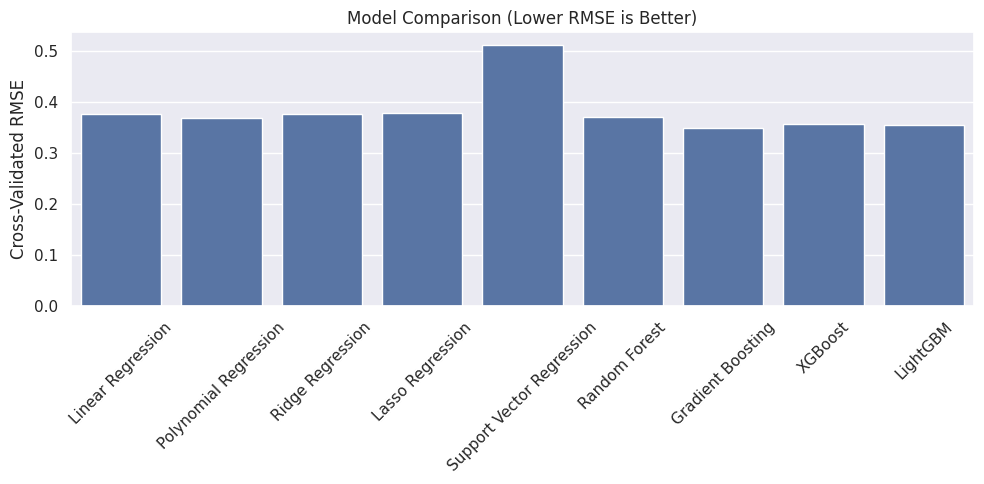

In [ ]:
def evaluate_model(model, X, y, name, results):
    # Create a pipeline with imputation inside the cross_val_score
    pipeline = make_pipeline(
        SimpleImputer(strategy='mean'),
        model
    )
    scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-scores)
    mean_rmse = rmse_scores.mean()
    results[name] = mean_rmse
    print(f"{name} - Mean RMSE: {mean_rmse:.4f} | Std: {rmse_scores.std():.4f}")

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": LinearRegression(),  # on poly features
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Support Vector Regression": SVR(kernel='rbf', C=1.0, epsilon=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
for name, model in models.items():
    if name == "Polynomial Regression":
        # Apply polynomial features before imputation in the pipeline
        pipeline = make_pipeline(
            PolynomialFeatures(degree=2, include_bias=False),
            SimpleImputer(strategy='mean'),
            model
        )
        evaluate_model(pipeline, X_train, y_train, name, results) # Pass X_train, not X_train_poly
    else:
        evaluate_model(model, X_train, y_train, name, results)

# 📊 Visualize the results
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Comparison (Lower RMSE is Better)")
plt.xticks(rotation=45)
plt.ylabel("Cross-Validated RMSE")
plt.tight_layout()
plt.show()

The above bar chart is a model comparison based on cross-validated RMSE (Root Mean Squared Error) values, where lower RMSE indicates better performance. It evaluates several regression models on the same dataset.

We observe that

a) Polynomial Regression has the lowest RMSE, suggesting it performed the best on this dataset in terms of predictive accuracy.

b) Gradient Boosting, XGBoost, and LightGBM also performed well, with RMSEs very close to Polynomial Regression.

c) Linear Regression, Ridge, and Lasso models have slightly higher RMSEs, indicating they may not capture complex relationships as well as the others.

d) Random Forest and Support Vector Regression fall in the middle — not the worst, but not the best.